In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#1. Installing Dependencies

In [ ]:
!pip install timm
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 59.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 118.6 MB/s eta 0:00:00


In [ ]:
!pip install -qU datasets transformers sentence-transformers \
                 pinecone-client pinecone-text protobuf==3.20.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.1/179.1 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.7/283.7 kB 15.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


#2. Loading Dataset

In [ ]:
from datasets import load_dataset

# load the dataset from huggingface datasets hub
fashion = load_dataset(
    "ashraq/fashion-product-images-small",
    split="train"
)
fashion

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/44072 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/ashraq___parquet/ashraq--fashion-product-images-small-909c61a107795b31/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7. Subsequent calls will reuse this data.


Dataset({
    features: ['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName', 'image'],
    num_rows: 44072
})

In [ ]:
# assign the images and metadata to separate variables
images = fashion["image"]
metadata = fashion.remove_columns("image")

In [ ]:
# convert metadata into a pandas dataframe
metadata=metadata
metadata = metadata.to_pandas()
metadata.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


#3. Setting up Configuration and Model

In [ ]:
import os
import cv2
import gc
import numpy as np
import pandas as pd
import itertools
from tqdm.autonotebook import tqdm
import albumentations as A
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
# import timm
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer

#New CLIP Model

In [ ]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.3 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-615nvzpx
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-615nvzpx
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369501 sha256=6b4a72d2fc5b741770b0d85d023290352ae43bc19d2f9bb77b85ca509afa0211
  Stored in directory: /tmp/pip-ephem-wheel-cache-l4zxe065/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


#4. Loading Models

##Model 1(10 epoch Finetuned Model)

In [ ]:
import clip
device = "cuda" if torch.cuda.is_available() else "cpu"
model_finetuned_1, preprocess = clip.load("ViT-B/32", device=device, jit=False)
model_finetuned_1.load_state_dict(torch.load("/content/drive/MyDrive/Saved_Model/CLIP_Fashion_new_Epoch10.pt"))

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 140MiB/s]


<All keys matched successfully>

##Model 2(30 epoch Finetuned Model)

In [ ]:
import clip
device = "cuda" if torch.cuda.is_available() else "cpu"
model_finetuned_2, preprocess = clip.load("ViT-B/32", device=device, jit=False)
model_finetuned_2.load_state_dict(torch.load("/content/drive/MyDrive/Saved_Model/CLIP_Fashion_new_Epoch30.pt"))

<All keys matched successfully>

##Model 3(50 epoch Finetuned Model)

In [ ]:
import clip
device = "cuda" if torch.cuda.is_available() else "cpu"
model_finetuned_3, preprocess = clip.load("ViT-B/32", device=device, jit=False)
model_finetuned_3.load_state_dict(torch.load("/content/drive/MyDrive/Saved_Model/CLIP_Fashion_new_Epoch50.pt"))

<All keys matched successfully>

##Model 4(80 epoch Finetuned Model)

In [ ]:
import clip
device = "cuda" if torch.cuda.is_available() else "cpu"
model_finetuned_4, preprocess = clip.load("ViT-B/32", device=device, jit=False)
model_finetuned_4.load_state_dict(torch.load("/content/drive/MyDrive/Saved_Model/CLIP_Fashion_new_Epoch80.pt"))

<All keys matched successfully>

##Model 5(100 epoch Finetuned Model)

In [ ]:
import clip
device = "cuda" if torch.cuda.is_available() else "cpu"
model_finetuned_5, preprocess = clip.load("ViT-B/32", device=device, jit=False)
model_finetuned_5.load_state_dict(torch.load("/content/drive/MyDrive/Saved_Model/CLIP_Fashion_new_Epoch100.pt"))

<All keys matched successfully>

##Model 6(FashionCLIP Model)

In [ ]:
!pip install -U fashion-clip

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.6/128.6 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 72.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 78.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 646.2/646.2 kB 50.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 85.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 33.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 81.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.2/70.2 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.6/547.6 kB 34.7 MB/s eta

In [ ]:
from fashion_clip.fashion_clip import FashionCLIP
device = "cuda" if torch.cuda.is_available() else "cpu"
model_fclip = FashionCLIP('fashion-clip')


##Model 7(Pinecone Benchmark Model)

In [ ]:
from sentence_transformers import SentenceTransformer
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# load a CLIP model from huggingface
model = SentenceTransformer(
    'sentence-transformers/clip-ViT-B-32',
    device=device
)
model

SentenceTransformer(
  (0): CLIPModel()
)

#5. Connecting to Pinecone and uploading embedding to Pinecone index

##5.1 For Model 1

### Connecting and Setting up Pinecone Index for model

In [ ]:
## Connect with the pine cone
import pinecone
# init connection to pinecone
pinecone.init(
    api_key="3c1215ea-8adb-4c61-a39a-e605bf37be57", # app.pinecone.io
    environment="asia-southeast1-gcp-free" # find next to api key
)

index_name = "hybrid-search1"

if index_name not in pinecone.list_indexes():
# create the index
 pinecone.create_index(
    index_name,
    dimension=512,
    metric="dotproduct",
    pod_type="Starter")

# pineconeIndex = pinecone.GRPCIndex(index_name)


In [ ]:
index1 = pinecone.Index(index_name)

In [ ]:
from pinecone_text.sparse import BM25Encoder
bm25 = BM25Encoder()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
meta_batch = metadata
bm25.fit(" ".join(x) for x in meta_batch.loc[:, ~meta_batch.columns.isin(['id', 'year'])])

0it [00:00, ?it/s]

### Uploading documents to pinecone index




In [ ]:
from tqdm.auto import tqdm

batch_size = 200

for i in tqdm(range(0, len(fashion), batch_size)):
    # find end of batch
    i_end = min(i+batch_size, len(fashion))
    # extract metadata batch
    meta_batch = metadata.iloc[i:i_end]
    meta_dict = meta_batch.to_dict(orient="records")
    # concatinate all metadata field except for id and year to form a single string
    meta_batch = [" ".join(x) for x in meta_batch.loc[:, ~meta_batch.columns.isin(['id', 'year'])].values.tolist()]
    # extract image batch
    img_batch = images[i:i_end]
    # create sparse BM25 vectors
    sparse_embeds = bm25.encode_documents([text for text in meta_batch])

    # create dense vectors
    dense_embeds=[]
    for img in img_batch:
        image = preprocess(img).unsqueeze(0).to(device)
        image_embedding=model_finetuned_1.encode_image(image).tolist()[0]
        dense_embeds.append(image_embedding)


    # create unique IDs
    ids = [str(x) for x in range(i, i_end)]

    upserts = []
    # loop through the data and create dictionaries for uploading documents to pinecone index
    for _id, sparse, dense, meta in zip(ids, sparse_embeds, dense_embeds, meta_dict):
        upserts.append({
            'id': _id,
            'sparse_values': sparse,
            'values': dense,
            'metadata': meta
        })
    # upload the documents to the new hybrid index
    index1.upsert(upserts)

# show index description after uploading the documents
index1.describe_index_stats()

##5.2 For Model 2

### Connecting and Setting up Pinecone Index for model

In [ ]:
## Connect with the pine cone
import pinecone
# init connection to pinecone
pinecone.init(
    api_key="77a9cc2e-58e0-48b3-8205-144bc2de9669", # app.pinecone.io
    environment="us-west4-gcp-free" # find next to api key
)

index_name = "hybrid-search2"

if index_name not in pinecone.list_indexes():
# create the index
 pinecone.create_index(
    index_name,
    dimension=512,
    metric="dotproduct",
    pod_type="Starter")

# pineconeIndex = pinecone.GRPCIndex(index_name)


In [ ]:
index2 = pinecone.Index(index_name)

In [ ]:
from pinecone_text.sparse import BM25Encoder
bm25 = BM25Encoder()

In [ ]:
meta_batch = metadata
bm25.fit(" ".join(x) for x in meta_batch.loc[:, ~meta_batch.columns.isin(['id', 'year'])])

0it [00:00, ?it/s]

### Uploading documents to pinecone index




In [ ]:
from tqdm.auto import tqdm

batch_size = 200

for i in tqdm(range(0, len(fashion), batch_size)):
    # find end of batch
    i_end = min(i+batch_size, len(fashion))
    # extract metadata batch
    meta_batch = metadata.iloc[i:i_end]
    meta_dict = meta_batch.to_dict(orient="records")
    # concatinate all metadata field except for id and year to form a single string
    meta_batch = [" ".join(x) for x in meta_batch.loc[:, ~meta_batch.columns.isin(['id', 'year'])].values.tolist()]
    # extract image batch
    img_batch = images[i:i_end]
    # create sparse BM25 vectors
    sparse_embeds = bm25.encode_documents([text for text in meta_batch])

    # create dense vectors
    dense_embeds=[]
    for img in img_batch:
        image = preprocess(img).unsqueeze(0).to(device)
        image_embedding=model_finetuned_2.encode_image(image).tolist()[0]
        dense_embeds.append(image_embedding)


    # create unique IDs
    ids = [str(x) for x in range(i, i_end)]

    upserts = []
    # loop through the data and create dictionaries for uploading documents to pinecone index
    for _id, sparse, dense, meta in zip(ids, sparse_embeds, dense_embeds, meta_dict):
        upserts.append({
            'id': _id,
            'sparse_values': sparse,
            'values': dense,
            'metadata': meta
        })
    # upload the documents to the new hybrid index
    index2.upsert(upserts)

# show index description after uploading the documents
index2.describe_index_stats()

##5.2 For Model 3

### Connecting and Setting up Pinecone Index for model

In [ ]:
## Connect with the pine cone
import pinecone
# init connection to pinecone
pinecone.init(
    api_key="606a16f5-3b6e-4444-8d80-b1ec519330ef", # app.pinecone.io
    environment="asia-northeast1-gcp" # find next to api key
)

index_name = "hybrid-search3"

if index_name not in pinecone.list_indexes():
# create the index
 pinecone.create_index(
    index_name,
    dimension=512,
    metric="dotproduct",
    pod_type="Starter")

# pineconeIndex = pinecone.GRPCIndex(index_name)


In [ ]:
index3 = pinecone.Index(index_name)

In [ ]:
from pinecone_text.sparse import BM25Encoder
bm25 = BM25Encoder()

In [ ]:
meta_batch = metadata
bm25.fit(" ".join(x) for x in meta_batch.loc[:, ~meta_batch.columns.isin(['id', 'year'])])

0it [00:00, ?it/s]

### Uploading documents to pinecone index




In [ ]:
from tqdm.auto import tqdm

batch_size = 200

for i in tqdm(range(0, len(fashion), batch_size)):
    # find end of batch
    i_end = min(i+batch_size, len(fashion))
    # extract metadata batch
    meta_batch = metadata.iloc[i:i_end]
    meta_dict = meta_batch.to_dict(orient="records")
    # concatinate all metadata field except for id and year to form a single string
    meta_batch = [" ".join(x) for x in meta_batch.loc[:, ~meta_batch.columns.isin(['id', 'year'])].values.tolist()]
    # extract image batch
    img_batch = images[i:i_end]
    # create sparse BM25 vectors
    sparse_embeds = bm25.encode_documents([text for text in meta_batch])

    # create dense vectors
    dense_embeds=[]
    for img in img_batch:
        image = preprocess(img).unsqueeze(0).to(device)
        image_embedding=model_finetuned_3.encode_image(image).tolist()[0]
        dense_embeds.append(image_embedding)


    # create unique IDs
    ids = [str(x) for x in range(i, i_end)]

    upserts = []
    # loop through the data and create dictionaries for uploading documents to pinecone index
    for _id, sparse, dense, meta in zip(ids, sparse_embeds, dense_embeds, meta_dict):
        upserts.append({
            'id': _id,
            'sparse_values': sparse,
            'values': dense,
            'metadata': meta
        })
    # upload the documents to the new hybrid index
    index3.upsert(upserts)

# show index description after uploading the documents
index3.describe_index_stats()

##5.3 For Model 4

### Connecting and Setting up Pinecone Index for model

In [ ]:
## Connect with the pine cone
import pinecone
# init connection to pinecone
pinecone.init(
    api_key="0d018028-450f-49ad-ae80-78d8d6961187", # app.pinecone.io
    environment="us-west4-gcp-free" # find next to api key
)

index_name = "hybrid-search6"

if index_name not in pinecone.list_indexes():
# create the index
 pinecone.create_index(
    index_name,
    dimension=512,
    metric="dotproduct",
    pod_type="Starter")

# pineconeIndex = pinecone.GRPCIndex(index_name)


In [ ]:
index4 = pinecone.Index(index_name)

In [ ]:
from pinecone_text.sparse import BM25Encoder
bm25 = BM25Encoder()

In [ ]:
meta_batch = metadata
bm25.fit(" ".join(x) for x in meta_batch.loc[:, ~meta_batch.columns.isin(['id', 'year'])])

0it [00:00, ?it/s]

### Uploading documents to pinecone index




In [ ]:
from tqdm.auto import tqdm

batch_size = 200

for i in tqdm(range(0, len(fashion), batch_size)):
    # find end of batch
    i_end = min(i+batch_size, len(fashion))
    # extract metadata batch
    meta_batch = metadata.iloc[i:i_end]
    meta_dict = meta_batch.to_dict(orient="records")
    # concatinate all metadata field except for id and year to form a single string
    meta_batch = [" ".join(x) for x in meta_batch.loc[:, ~meta_batch.columns.isin(['id', 'year'])].values.tolist()]
    # extract image batch
    img_batch = images[i:i_end]
    # create sparse BM25 vectors
    sparse_embeds = bm25.encode_documents([text for text in meta_batch])

    # create dense vectors
    dense_embeds=[]
    for img in img_batch:
        image = preprocess(img).unsqueeze(0).to(device)
        image_embedding=model_finetuned_4.encode_image(image).tolist()[0]
        dense_embeds.append(image_embedding)


    # create unique IDs
    ids = [str(x) for x in range(i, i_end)]

    upserts = []
    # loop through the data and create dictionaries for uploading documents to pinecone index
    for _id, sparse, dense, meta in zip(ids, sparse_embeds, dense_embeds, meta_dict):
        upserts.append({
            'id': _id,
            'sparse_values': sparse,
            'values': dense,
            'metadata': meta
        })
    # upload the documents to the new hybrid index
    index4.upsert(upserts)

# show index description after uploading the documents
index4.describe_index_stats()

##5.4 For Model 5

### Connecting and Setting up Pinecone Index for model

In [ ]:
## Connect with the pine cone
import pinecone
# init connection to pinecone
pinecone.init(
    api_key="c2f093cb-64f0-450d-a718-4a6df175eb15", # app.pinecone.io
    environment="us-west4-gcp-free" # find next to api key
)

index_name = "hybrid-search4"

if index_name not in pinecone.list_indexes():
# create the index
 pinecone.create_index(
    index_name,
    dimension=512,
    metric="dotproduct",
    pod_type="Starter")

# pineconeIndex = pinecone.GRPCIndex(index_name)


In [ ]:
index5 = pinecone.Index(index_name)

In [ ]:
from pinecone_text.sparse import BM25Encoder
bm25 = BM25Encoder()

In [ ]:
meta_batch = metadata
bm25.fit(" ".join(x) for x in meta_batch.loc[:, ~meta_batch.columns.isin(['id', 'year'])])

0it [00:00, ?it/s]

### Uploading documents to pinecone index




In [ ]:
from tqdm.auto import tqdm

batch_size = 200

for i in tqdm(range(0, len(fashion), batch_size)):
    # find end of batch
    i_end = min(i+batch_size, len(fashion))
    # extract metadata batch
    meta_batch = metadata.iloc[i:i_end]
    meta_dict = meta_batch.to_dict(orient="records")
    # concatinate all metadata field except for id and year to form a single string
    meta_batch = [" ".join(x) for x in meta_batch.loc[:, ~meta_batch.columns.isin(['id', 'year'])].values.tolist()]
    # extract image batch
    img_batch = images[i:i_end]
    # create sparse BM25 vectors
    sparse_embeds = bm25.encode_documents([text for text in meta_batch])

    # create dense vectors
    dense_embeds=[]
    for img in img_batch:
        image = preprocess(img).unsqueeze(0).to(device)
        image_embedding=model_finetuned_5.encode_image(image).tolist()[0]
        dense_embeds.append(image_embedding)


    # create unique IDs
    ids = [str(x) for x in range(i, i_end)]

    upserts = []
    # loop through the data and create dictionaries for uploading documents to pinecone index
    for _id, sparse, dense, meta in zip(ids, sparse_embeds, dense_embeds, meta_dict):
        upserts.append({
            'id': _id,
            'sparse_values': sparse,
            'values': dense,
            'metadata': meta
        })
    # upload the documents to the new hybrid index
    index5.upsert(upserts)

# show index description after uploading the documents
index5.describe_index_stats()

##5.5 For Model 6

### Connecting and Setting up Pinecone Index for model

In [ ]:
## Connect with the pine cone
import pinecone
# init connection to pinecone
pinecone.init(
    api_key="454041ca-4d6b-482a-b79b-ea0345dd16ef", # app.pinecone.io
    environment="us-west4-gcp-free" # find next to api key
)

index_name = "hybrid-search5"

if index_name not in pinecone.list_indexes():
# create the index
 pinecone.create_index(
    index_name,
    dimension=512,
    metric="dotproduct",
    pod_type="Starter")

# pineconeIndex = pinecone.GRPCIndex(index_name)


In [ ]:
index6 = pinecone.Index(index_name)

In [ ]:
from pinecone_text.sparse import BM25Encoder
bm25 = BM25Encoder()

In [ ]:
meta_batch = metadata
bm25.fit(" ".join(x) for x in meta_batch.loc[:, ~meta_batch.columns.isin(['id', 'year'])])

0it [00:00, ?it/s]

### Uploading documents to pinecone index




In [ ]:
from tqdm.auto import tqdm

batch_size = 200

for i in tqdm(range(0, len(fashion), batch_size)):
    # find end of batch
    i_end = min(i+batch_size, len(fashion))
    # extract metadata batch
    meta_batch = metadata.iloc[i:i_end]
    meta_dict = meta_batch.to_dict(orient="records")
    # concatinate all metadata field except for id and year to form a single string
    meta_batch = [" ".join(x) for x in meta_batch.loc[:, ~meta_batch.columns.isin(['id', 'year'])].values.tolist()]
    # extract image batch
    img_batch = images[i:i_end]
    # create sparse BM25 vectors
    sparse_embeds = bm25.encode_documents([text for text in meta_batch])
    # create dense vectors
    dense_embeds = model_fclip.encode_images(img_batch,batch_size=1).tolist()
    # create unique IDs
    ids = [str(x) for x in range(i, i_end)]

    upserts = []
    # loop through the data and create dictionaries for uploading documents to pinecone index
    for _id, sparse, dense, meta in zip(ids, sparse_embeds, dense_embeds, meta_dict):
        upserts.append({
            'id': _id,
            'sparse_values': sparse,
            'values': dense,
            'metadata': meta
        })
    # upload the documents to the new hybrid index
    index6.upsert(upserts)

# show index description after uploading the documents
index6.describe_index_stats()

##5.1 Model 7(PineCone Standard Benchmark)

### Connecting and Setting up Pinecone Index for model without fine tuning

In [ ]:

# init connection to pinecone
pinecone.init(
    api_key="4b356ef2-97fb-43f4-bf14-bdd46de3486b", # app.pinecone.io
    environment="us-west1-gcp" # find next to api key
)

index_name = "hybrid-image-search"

if index_name not in pinecone.list_indexes():
# create the index
 pinecone.create_index(
    index_name,
    dimension=512,
    metric="dotproduct",
    pod_type="Starter")

In [ ]:
index_pine = pinecone.Index(index_name)

In [ ]:
from pinecone_text.sparse import BM25Encoder
bm25 = BM25Encoder()

In [ ]:
bm25.fit(metadata['productDisplayName'])

  0%|          | 0/44072 [00:00<?, ?it/s]

### Uploading documents to pinecone index




In [ ]:
from tqdm.auto import tqdm

batch_size = 200

for i in tqdm(range(0, len(fashion), batch_size)):
    # find end of batch
    i_end = min(i+batch_size, len(fashion))
    # extract metadata batch
    meta_batch = metadata.iloc[i:i_end]
    meta_dict = meta_batch.to_dict(orient="records")
    # concatinate all metadata field except for id and year to form a single string
    meta_batch = [" ".join(x) for x in meta_batch.loc[:, ~meta_batch.columns.isin(['id', 'year'])].values.tolist()]
    # extract image batch
    img_batch = images[i:i_end]
    # create sparse BM25 vectors
    sparse_embeds = bm25.encode_documents([text for text in meta_batch])
    # create dense vectors
    dense_embeds = model.encode(img_batch).tolist()
    # create unique IDs
    ids = [str(x) for x in range(i, i_end)]

    upserts = []
    # loop through the data and create dictionaries for uploading documents to pinecone index
    for _id, sparse, dense, meta in zip(ids, sparse_embeds, dense_embeds, meta_dict):
        upserts.append({
            'id': _id,
            'sparse_values': sparse,
            'values': dense,
            'metadata': meta
        })
    # upload the documents to the new hybrid index
    index_pine.upsert(upserts)

# show index description after uploading the documents
index_pine.describe_index_stats()

In [ ]:
# len()
# text = clip.tokenize(query).to(device)
# query="hey".tolist()
dense=model_fclip.encode_text(["a pair of pink shorts"], 32)[0]
len(dense)

#TNSE function

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


def TNSE_vis(ids1,ids2,ids3,ids4,ids5,ids6,ids7):
      encoded_images1=[]
      encoded_images2=[]
      encoded_images3=[]
      encoded_images4=[]
      encoded_images5=[]
      encoded_images6=[]
      encoded_images7=[]
      for i in ids1:
        PIL_image = preprocess(images[i]).unsqueeze(0).to(device)
        encoded_images1.append(model_finetuned_1.encode_image(PIL_image).tolist())

      for i in ids2:
        PIL_image = preprocess(images[i]).unsqueeze(0).to(device)
        encoded_images2.append(model_finetuned_2.encode_image(PIL_image).tolist())

      for i in ids3:
        PIL_image = preprocess(images[i]).unsqueeze(0).to(device)
        encoded_images3.append(model_finetuned_3.encode_image(PIL_image).tolist())

      for i in ids4:
        PIL_image = preprocess(images[i]).unsqueeze(0).to(device)
        encoded_images4.append(model_finetuned_4.encode_image(PIL_image).tolist())

      for i in ids5:
        PIL_image = preprocess(images[i]).unsqueeze(0).to(device)
        encoded_images5.append(model_finetuned_5.encode_image(PIL_image).tolist())


      for i in ids6:
        # PIL_image = preprocess(images[i]).unsqueeze(0).to(device)
        encoded_images6.append(model_fclip.encode_images([images[i]], 32))

      for i in ids7:
        encoded_images7.append(model.encode(images[i]).tolist())





      # Convert the list to a numpy array
      encoded_images1_array = np.array(encoded_images1)
      encoded_images2_array = np.array(encoded_images2)
      encoded_images3_array = np.array(encoded_images3)
      encoded_images4_array = np.array(encoded_images4)
      encoded_images5_array = np.array(encoded_images5)
      encoded_images6_array = np.array(encoded_images6)
      encoded_images7_array = np.array(encoded_images7)

      # Reshape the encoded images to have two dimensions
      encoder1_images_flat = encoded_images1_array.reshape(10, 512)
      encoder2_images_flat = encoded_images2_array.reshape(10, 512)
      encoder3_images_flat = encoded_images3_array.reshape(10, 512)
      encoder4_images_flat = encoded_images4_array.reshape(10, 512)
      encoder5_images_flat = encoded_images5_array.reshape(10, 512)
      encoder6_images_flat = encoded_images6_array.reshape(10, 512)
      encoder7_images_flat = encoded_images7_array.reshape(10, 512)


      # Concatenate the flattened encoded images from all encoders
      encoded_images = np.concatenate((encoder1_images_flat, encoder2_images_flat,encoder3_images_flat, encoder4_images_flat,encoder5_images_flat, encoder6_images_flat,encoder7_images_flat), axis=0)

      # Perform t-SNE dimensionality reduction
      X_embedded = TSNE(n_components=2, random_state=42, perplexity=6).fit_transform(encoded_images)

      # Define the labels for each encoded image
      labels = [i  for i in ids1] + [j for j in ids2]+[k  for k in ids3] + [l for l in ids4]+[m  for m in ids5] + [n for n in ids6]+[o  for o in ids7]

      # Define the color map for each encoder
      encoder_colors = ['yellow'] * 10 + ['orange'] * 10+ ['blue'] * 10 + ['green'] * 10 +['purple'] * 10  + ['red'] * 10 + ['black'] * 10

      # Create the scatter plot with labels and color
      plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=encoder_colors,label=labels)

      # Add labels to each point
      for i, label in enumerate(labels):
          plt.annotate(label, (X_embedded[i, 0], X_embedded[i, 1]))

      plt.colorbar()
      plt.show()

#Text-Image Search


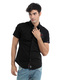
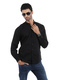
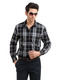
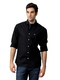
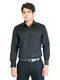
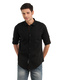
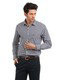
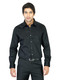
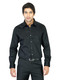
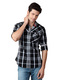

[12345, 34155, 22616, 17900, 4187, 3398, 41064, 12417, 34322, 43245]
 



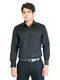
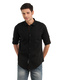
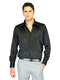
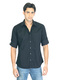
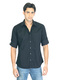
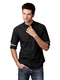
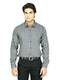
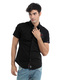
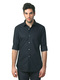
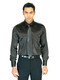

[4187, 3398, 41109, 1416, 7013, 21633, 5202, 12345, 10351, 27245]
 



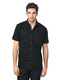
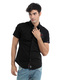
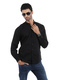
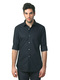
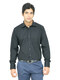
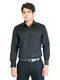
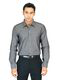
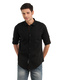
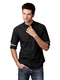
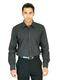

[37203, 12345, 34155, 10351, 29863, 4187, 3519, 3398, 21633, 42532]
 



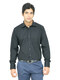
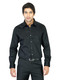
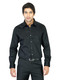
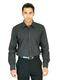
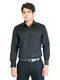
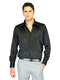
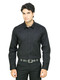
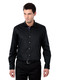
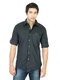
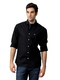

[29863, 34322, 12417, 42532, 4187, 41109, 34616, 7275, 30203, 17900]
 



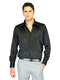
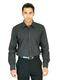
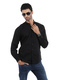
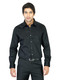
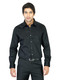
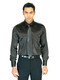
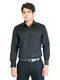
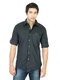
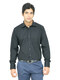
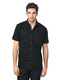

[41109, 42532, 34155, 34322, 12417, 27245, 4187, 30203, 29863, 37203]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

1it [00:00, 44.64it/s]



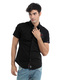
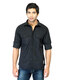
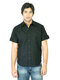
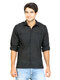
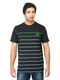
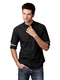
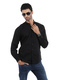
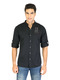
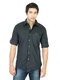
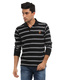

[12345, 39215, 31909, 34293, 20679, 21633, 34155, 8779, 30203, 41896]
 



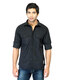
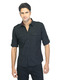
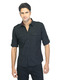
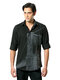
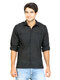
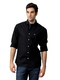
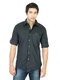
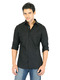
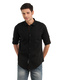
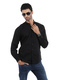

[39215, 22244, 34999, 37845, 34293, 17900, 30203, 10742, 3398, 34155]


1it [00:00, 35.86it/s]
1it [00:00, 22.38it/s]
1it [00:00, 21.35it/s]
1it [00:00, 37.35it/s]
1it [00:00, 36.75it/s]
1it [00:00, 24.43it/s]
1it [00:00, 37.80it/s]
1it [00:00, 40.81it/s]
1it [00:00, 37.99it/s]
1it [00:00, 29.22it/s]


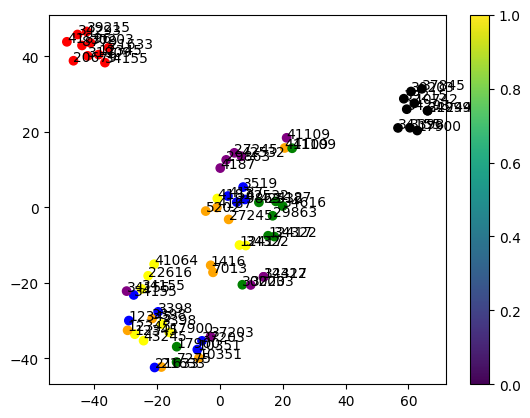

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
from IPython.display import display, Image
from IPython.core.display import HTML
from io import BytesIO
from base64 import b64encode

def hybrid_scale(dense, sparse, alpha: float):
    """Hybrid vector scaling using a convex combination

    alpha * dense + (1 - alpha) * sparse

    Args:
        dense: Array of floats representing
        sparse: a dict of `indices` and `values`
        alpha: float between 0 and 1 where 0 == sparse only
               and 1 == dense only
    """
    if alpha < 0 or alpha > 1:
        raise ValueError("Alpha must be between 0 and 1")
    # scale sparse and dense vectors to create hybrid search vecs
    hsparse = {
        'indices': sparse['indices'],
        'values':  [v * (1 - alpha) for v in sparse['values']]
    }
    hdense = [v * alpha for v in dense]
    return hdense, hsparse


def display_result_in_loop(image_batch):
    figures = []
    for img in image_batch:
        b = BytesIO()
        img.save(b, format='png')
        img_data = b.getvalue()
        img_encoded = b64encode(img_data).decode('utf-8')
        img_tag = f'<img src="data:image/png;base64,{img_encoded}" style="width: 80px; height: 80px;">'
        figures.append(img_tag)
    html = '<div style="display: flex; flex-wrap: wrap;">' + ''.join(figures) + '</div>'
    display(HTML(html))









query_list = [
# "Give me blue colored tote handbag for women"
# "Give me black backpack",
# "Give me red duffle bag",
# "Give me orange rucksacks",
# "Give me red clutches"


# "Give me half sleeved red tshirt for men"

# "Give me stripped black shirt for men"
# "Give me polo neck black tshirt for men"
# "Give me half sleeved black tshirt for women",
# "Give me black colored jeans for men"
# "Give me black shorts for women",
# "Give me jeans pants for women"

# "Give me black sports shoes for men",
# "Give me leather sandals for men",
# "Give me casual shoes for men",
# "Give me formal shoes for men",
# "Give me green color sports shoes for men",


# "Give me pink colored lipstick",
# "Give me red colored matte lipstick",
# "Give me foundation cream",
# "Give me red colored nailpolish",
# "Give me perfumes for men"


###########################################################
# "A photo of dark color kurta with flower patterns",
# "A photo of dark color kurta with flower patterns for women",
# "A photo of dark color kurta with floral patterns",
# "A photo of light color kurta for women",
# "A photo of light color kurta with floral pattern",
# "A photo of rectangular watch",
# "A photo of digital watch",
# "A photo of analog watch",
# "A photo of t-shirt with cartoon logo",
# "A photo of vertical wallets",
# "A photo of horizontal wallets",
# "A photo of green and white shoes for running",
# "A photo of green and white shoes for walking",
# "A photo of striped shirts",
# "A photo of red striped shirts",
# "A photo of red striped Tshirts",
# "A photo of bucket shaped handbag",
# "A photo of boat shaped handbag",
# "A photo of flower logo t-shirts",
# "A photo of yellow Shoes with green color",
# "A photo of red-Tshirt for men",
# "A photo of red-Tshirt for women",
# "A photo of black Pants for men",
# "A photo of shorts",
# "A photo of flipflops",
# "A photo of black bagpack",
# "A photo of kids dress",
# "A photo of yellow Tshirts for men",
# "A photo of black and white stripped Tshirts for men",
# "A photo of sling bag",
# "A photo of orange color backpacks",
# "A photo of embroidered sarees",
# "A photo of ethnic kurta sets for men",
# "A photo of colorful bangles for festivities",
# "A photo of jhumka earrings for women",
# "A photo of handcrafted leather sandals for men",
# "A photo of cotton salwar kameez sets for women",
# "A photo of sarees for weddings",
# "A photo of artificial jewelry sets for style"


]

alpha_value_list = [1]

for query in query_list:
    html = "<h1><b>Query: </b>" + query + "</h1>"
    display(HTML(html))
    for alpha in alpha_value_list:

        #Model 1
        # Create sparse and dense vectors
        sparse = bm25.encode_queries("Hello World")
        text = clip.tokenize(query).to(device)
        dense=model_finetuned_1.encode_text(text).tolist()[0]
        # Scale sparse and dense vectors - keyword search first
        hdense, hsparse = hybrid_scale(dense, sparse, alpha=alpha)
        # Search
        result = index1.query(
            top_k=10,
            vector=hdense,
            sparse_vector=hsparse,
            include_metadata=True
        )
        print(" ")
        html="<h2><b>Model 1(Epoch 10: FineTuned Model): </b></h2>"
        # display(HTML(html))
        # html="<i>For Alpha: </i>"+str(alpha)
        # display(HTML(html))
        # html="<u>Image Results:</u>"
        display(HTML(html))
        # Use returned product ids to get images
        imgs = [images[int(r["id"])] for r in result["matches"]]
        # Display the images
        ids1 = [int(r["id"]) for r in result["matches"]]
        display_result_in_loop(imgs)
        print(ids1)





        #Model 2
        # Create sparse and dense vectors
        sparse = bm25.encode_queries("Hello World")
        text = clip.tokenize(query).to(device)
        dense=model_finetuned_2.encode_text(text).tolist()[0]
        # Scale sparse and dense vectors - keyword search first
        hdense, hsparse = hybrid_scale(dense, sparse, alpha=alpha)
        # Search
        result = index2.query(
            top_k=10,
            vector=hdense,
            sparse_vector=hsparse,
            include_metadata=True
        )
        print(" ")
        html="<h2><b>Model 2(Epoch 30: FineTuned Model): </b></h2>"
        # display(HTML(html))
        # html="<i>For Alpha: </i>"+str(alpha)
        # display(HTML(html))
        # html="<u>Image Results:</u>"
        display(HTML(html))
        # Use returned product ids to get images
        imgs = [images[int(r["id"])] for r in result["matches"]]
        # Display the images
        ids2 = [int(r["id"]) for r in result["matches"]]
        display_result_in_loop(imgs)
        print(ids2)







        #Model 3
        # Create sparse and dense vectors
        sparse = bm25.encode_queries("Hello World")
        text = clip.tokenize(query).to(device)
        dense=model_finetuned_3.encode_text(text).tolist()[0]
        # Scale sparse and dense vectors - keyword search first
        hdense, hsparse = hybrid_scale(dense, sparse, alpha=alpha)
        # Search
        result = index3.query(
            top_k=10,
            vector=hdense,
            sparse_vector=hsparse,
            include_metadata=True
        )
        print(" ")
        html="<h2><b>Model 3(Epoch 50: FineTuned Model): </b></h2>"
        # display(HTML(html))
        # html="<i>For Alpha: </i>"+str(alpha)
        # display(HTML(html))
        # html="<u>Image Results:</u>"
        display(HTML(html))
        # Use returned product ids to get images
        imgs = [images[int(r["id"])] for r in result["matches"]]
        # Display the images
        ids3 = [int(r["id"]) for r in result["matches"]]
        display_result_in_loop(imgs)
        print(ids3)





        #Model 4
        # Create sparse and dense vectors
        sparse = bm25.encode_queries("Hello World")
        text = clip.tokenize(query).to(device)
        dense=model_finetuned_4.encode_text(text).tolist()[0]
        # Scale sparse and dense vectors - keyword search first
        hdense, hsparse = hybrid_scale(dense, sparse, alpha=alpha)
        # Search
        result = index4.query(
            top_k=10,
            vector=hdense,
            sparse_vector=hsparse,
            include_metadata=True
        )
        print(" ")
        html="<h2><b>Model 4(Epoch 80: FineTuned Model): </b></h2>"
        # display(HTML(html))
        # html="<i>For Alpha: </i>"+str(alpha)
        # display(HTML(html))
        # html="<u>Image Results:</u>"
        display(HTML(html))
        # Use returned product ids to get images
        imgs = [images[int(r["id"])] for r in result["matches"]]
        # Display the images
        ids4 = [int(r["id"]) for r in result["matches"]]
        display_result_in_loop(imgs)
        print(ids4)


        #Model 5
        # Create sparse and dense vectors
        sparse = bm25.encode_queries("Hello World")
        text = clip.tokenize(query).to(device)
        dense=model_finetuned_5.encode_text(text).tolist()[0]
        # Scale sparse and dense vectors - keyword search first
        hdense, hsparse = hybrid_scale(dense, sparse, alpha=alpha)
        # Search
        result = index5.query(
            top_k=10,
            vector=hdense,
            sparse_vector=hsparse,
            include_metadata=True
        )
        print(" ")
        html="<h2><b>Model 5(Epoch 100: FineTuned Model): </b></h2>"
        # display(HTML(html))
        # html="<i>For Alpha: </i>"+str(alpha)
        # display(HTML(html))
        # html="<u>Image Results:</u>"
        display(HTML(html))
        # Use returned product ids to get images
        imgs = [images[int(r["id"])] for r in result["matches"]]
        # Display the images
        ids5 = [int(r["id"]) for r in result["matches"]]
        display_result_in_loop(imgs)
        print(ids5)



        #Model 6
        # Create sparse and dense vectors
        sparse = bm25.encode_queries("Hello World")
        # text = clip.tokenize(query).to(device)
        dense=model_fclip.encode_text([query], 32)[0]
        # Scale sparse and dense vectors - keyword search first
        hdense, hsparse = hybrid_scale(dense, sparse, alpha=alpha)
        # Search
        result = index6.query(
            top_k=10,
            vector=hdense,
            sparse_vector=hsparse,
            include_metadata=True
        )
        print(" ")
        html="<h2><b>Model 6(FashionCLIP Model): </b></h2>"
        # display(HTML(html))
        # html="<i>For Alpha: </i>"+str(alpha)
        # display(HTML(html))
        # html="<u>Image Results:</u>"
        display(HTML(html))
        # Use returned product ids to get images
        imgs = [images[int(r["id"])] for r in result["matches"]]
        # Display the images
        ids6 = [int(r["id"]) for r in result["matches"]]
        display_result_in_loop(imgs)
        print(ids6)





        #Pinecone Standard Benchmark Model
        # Create sparse and dense vectors
        sparse = bm25.encode_queries("Hello World")
        dense =  model.encode(query).tolist()
        # Scale sparse and dense vectors - keyword search first
        hdense, hsparse = hybrid_scale(dense, sparse, alpha=alpha)
        # Search
        result = index_pine.query(
            top_k=10,
            vector=hdense,
            sparse_vector=hsparse,
            include_metadata=True
        )
        print(" ")
        html="<h2><b>Model 7(PineCone Standard Model): </b></h2>"
        # display(HTML(html))
        # html="<i>For Alpha: </i>"+str(alpha)
        # display(HTML(html))
        # html="<u>Image Results:</u>"
        display(HTML(html))
        # Use returned product ids to get images
        imgs = [images[int(r["id"])] for r in result["matches"]]
        # Display the images
        ids7 = [int(r["id"]) for r in result["matches"]]
        display_result_in_loop(imgs)
        print(ids7)

    TNSE_vis(ids1,ids2,ids3,ids4,ids5,ids6,ids7)
    print("-" * 250)

#Visualization

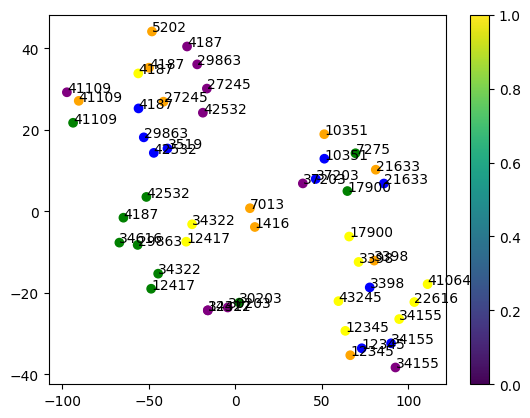

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

encoded_images1=[]
encoded_images2=[]
encoded_images3=[]
encoded_images4=[]
encoded_images5=[]
encoded_images6=[]
encoded_images7=[]



for i in ids1:
  PIL_image = preprocess(images[i]).unsqueeze(0).to(device)
  encoded_images1.append(model_finetuned_1.encode_image(PIL_image).tolist())

for i in ids2:
  PIL_image = preprocess(images[i]).unsqueeze(0).to(device)
  encoded_images2.append(model_finetuned_2.encode_image(PIL_image).tolist())

for i in ids3:
  PIL_image = preprocess(images[i]).unsqueeze(0).to(device)
  encoded_images3.append(model_finetuned_3.encode_image(PIL_image).tolist())

for i in ids4:
  PIL_image = preprocess(images[i]).unsqueeze(0).to(device)
  encoded_images4.append(model_finetuned_4.encode_image(PIL_image).tolist())

for i in ids5:
  PIL_image = preprocess(images[i]).unsqueeze(0).to(device)
  encoded_images5.append(model_finetuned_5.encode_image(PIL_image).tolist())


# for i in ids6:
#   # PIL_image = preprocess(images[i]).unsqueeze(0).to(device)
#   encoded_images6.append(model_fclip.encode_images([images[i]], 32))

# for i in ids7:
#   encoded_images7.append(model.encode(images[i]).tolist())





# Convert the list to a numpy array
encoded_images1_array = np.array(encoded_images1)
encoded_images2_array = np.array(encoded_images2)
encoded_images3_array = np.array(encoded_images3)
encoded_images4_array = np.array(encoded_images4)
encoded_images5_array = np.array(encoded_images5)
# encoded_images6_array = np.array(encoded_images6)
# encoded_images7_array = np.array(encoded_images7)

# Reshape the encoded images to have two dimensions
encoder1_images_flat = encoded_images1_array.reshape(10, 512)
encoder2_images_flat = encoded_images2_array.reshape(10, 512)
encoder3_images_flat = encoded_images3_array.reshape(10, 512)
encoder4_images_flat = encoded_images4_array.reshape(10, 512)
encoder5_images_flat = encoded_images5_array.reshape(10, 512)
# encoder6_images_flat = encoded_images6_array.reshape(10, 512)
# encoder7_images_flat = encoded_images7_array.reshape(10, 512)


# Concatenate the flattened encoded images from all encoders
encoded_images = np.concatenate((encoder1_images_flat, encoder2_images_flat,encoder3_images_flat, encoder4_images_flat,encoder5_images_flat), axis=0)

# Perform t-SNE dimensionality reduction
X_embedded = TSNE(n_components=2, random_state=42, perplexity=6).fit_transform(encoded_images)

# Define the labels for each encoded image
labels = [i  for i in ids1] + [j for j in ids2]+[k  for k in ids3] + [l for l in ids4]+[m  for m in ids5]
# Define the color map for each encoder
encoder_colors = ['yellow'] * 10 + ['orange'] * 10+ ['blue'] * 10 + ['green'] * 10 +['purple'] * 10

# Create the scatter plot with labels and color
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=encoder_colors,label=labels)

# Add labels to each point
for i, label in enumerate(labels):
    plt.annotate(label, (X_embedded[i, 0], X_embedded[i, 1]))

plt.colorbar()
plt.show()


#K means clustering

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-487-87c67b079646>:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', len(set(cluster_labels)))


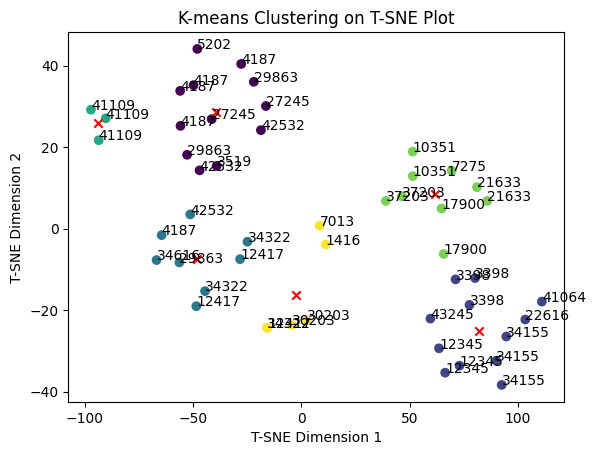

In [ ]:
import torch

cluster_label=[]

# # Concatenate the flattened encoded images from all encoders
encoded_images = np.concatenate((encoder1_images_flat, encoder2_images_flat,encoder3_images_flat, encoder4_images_flat,encoder5_images_flat), axis=0)

# # Perform t-SNE dimensionality reduction
X_embedded = TSNE(n_components=2, random_state=42, perplexity=6).fit_transform(encoded_images)

from sklearn.cluster import KMeans

# Assuming you have T-SNE plot data points as a numpy array called 'tsne_data'
# tsne_data shape: (num_points, 2)

# Initialize the KMeans object with k=5 clusters
kmeans = KMeans(n_clusters=6)

# Fit the K-means model to the T-SNE data
kmeans.fit(X_embedded)

# Get the cluster labels for each data point
cluster_labels = kmeans.labels_

# Get the centroids of each cluster
centroids = kmeans.cluster_centers_


import matplotlib.pyplot as plt


# Assuming you have the cluster labels and centroids from the K-means algorithm

# Define a color map for the clusters
color_map = plt.cm.get_cmap('viridis', len(set(cluster_labels)))

# Scatter plot the T-SNE data points colored by cluster labels
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=cluster_labels, cmap=color_map)


# # Define the color map for each encoder
# encoder_colors = ['yellow']  + ['orange'] + ['blue'] + ['green']



# Plot the centroids as markers with a different color
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x')

# Define the labels for each encoded image
labels = [i  for i in ids1] + [j for j in ids2]+[k  for k in ids3] + [l for l in ids4]+[m  for m in ids5]


for i, label in enumerate(labels):
    cluster_label.append(label)
    plt.annotate(label, (X_embedded[i, 0], X_embedded[i, 1]))

# Add labels and title to the plot
plt.xlabel('T-SNE Dimension 1')
plt.ylabel('T-SNE Dimension 2')
plt.title('K-means Clustering on T-SNE Plot')

# Show the plot
plt.show()

In [ ]:
cluster_label

[12345,
 34155,
 22616,
 17900,
 4187,
 3398,
 41064,
 12417,
 34322,
 43245,
 4187,
 3398,
 41109,
 1416,
 7013,
 21633,
 5202,
 12345,
 10351,
 27245,
 37203,
 12345,
 34155,
 10351,
 29863,
 4187,
 3519,
 3398,
 21633,
 42532,
 29863,
 34322,
 12417,
 42532,
 4187,
 41109,
 34616,
 7275,
 30203,
 17900,
 41109,
 42532,
 34155,
 34322,
 12417,
 27245,
 4187,
 30203,
 29863,
 37203]

In [ ]:
len(cluster_label)

50

In [ ]:
print(cluster_label[2])

22616


#6. Cluster analysis

In [ ]:
ids=ids1+ids2+ids3+ids4+ids5

In [ ]:
ids

[12345,
 34155,
 22616,
 17900,
 4187,
 3398,
 41064,
 12417,
 34322,
 43245,
 4187,
 3398,
 41109,
 1416,
 7013,
 21633,
 5202,
 12345,
 10351,
 27245,
 37203,
 12345,
 34155,
 10351,
 29863,
 4187,
 3519,
 3398,
 21633,
 42532,
 29863,
 34322,
 12417,
 42532,
 4187,
 41109,
 34616,
 7275,
 30203,
 17900,
 41109,
 42532,
 34155,
 34322,
 12417,
 27245,
 4187,
 30203,
 29863,
 37203]

In [ ]:
ids_unique=set()

for i in ids:
  ids_unique.add(i)

In [ ]:
len(ids_unique)

24

In [ ]:
import pandas as pd

df_analysis=pd.DataFrame(ids_unique,columns =['Image_ids'])

In [ ]:
df_analysis

,Image_ids
0,12417
1,21633
2,1416
3,34322
4,41109
5,42532
6,29863
7,34616
8,12345
9,3519


In [ ]:
df_analysis['Epoch10'] = df_analysis['Image_ids'].apply(lambda x: 1 if x in ids1 else 0)
df_analysis['Epoch30'] = df_analysis['Image_ids'].apply(lambda x: 1 if x in ids2 else 0)
df_analysis['Epoch50'] = df_analysis['Image_ids'].apply(lambda x: 1 if x in ids3 else 0)
df_analysis['Epoch80'] = df_analysis['Image_ids'].apply(lambda x: 1 if x in ids4 else 0)
df_analysis['Epoch100'] = df_analysis['Image_ids'].apply(lambda x: 1 if x in ids5 else 0)

In [ ]:
df_analysis = df_analysis.sort_values(by = 'Image_ids')

In [ ]:
df_analysis

,Image_ids,Epoch10,Epoch30,Epoch50,Epoch80,Epoch100
2,1416,0,1,0,0,0
10,3398,1,1,1,0,0
9,3519,0,0,1,0,0
14,4187,1,1,1,1,1
11,5202,0,1,0,0,0
15,7013,0,1,0,0,0
22,7275,0,0,0,1,0
21,10351,0,1,1,0,0
8,12345,1,1,1,0,0
0,12417,1,0,0,1,1


In [ ]:
# Create a new column "SumColumn" and initialize it with zeros
df_analysis['frequency'] = 0

# Iterate over each row and calculate the sum
for index, row in df_analysis.iterrows():
    sum_value =row['Epoch10'] + row['Epoch30']+ row['Epoch50'] + row['Epoch80']+row['Epoch100']
    df_analysis.at[index, 'frequency'] = sum_value


In [ ]:
# df_analysis=df_analysis.drop(['SumColumn'], axis=1)
# df_analysis=df_analysis-df_analysis['sumColumn']
df_analysis

,Image_ids,Epoch10,Epoch30,Epoch50,Epoch80,Epoch100,frequency
2,1416,0,1,0,0,0,1
10,3398,1,1,1,0,0,3
9,3519,0,0,1,0,0,1
14,4187,1,1,1,1,1,5
11,5202,0,1,0,0,0,1
15,7013,0,1,0,0,0,1
22,7275,0,0,0,1,0,1
21,10351,0,1,1,0,0,2
8,12345,1,1,1,0,0,3
0,12417,1,0,0,1,1,3


In [ ]:
max_freq=max(df_analysis['frequency'])

In [ ]:
max_freq_ids=[]
for index, row in df_analysis.iterrows():
  if row['frequency']==max_freq:
    max_freq_ids.append(row['Image_ids'])


In [ ]:
max_freq_ids

[4187]

In [ ]:
k_means_cluster_label=[]

In [ ]:
for i,j in enumerate(cluster_labels):
  k_means_cluster_label.append([cluster_label[i],j])

In [ ]:
k_means_cluster_label

[[12345, 1],
 [34155, 1],
 [22616, 1],
 [17900, 4],
 [4187, 0],
 [3398, 1],
 [41064, 1],
 [12417, 2],
 [34322, 2],
 [43245, 1],
 [4187, 0],
 [3398, 1],
 [41109, 3],
 [1416, 5],
 [7013, 5],
 [21633, 4],
 [5202, 0],
 [12345, 1],
 [10351, 4],
 [27245, 0],
 [37203, 4],
 [12345, 1],
 [34155, 1],
 [10351, 4],
 [29863, 0],
 [4187, 0],
 [3519, 0],
 [3398, 1],
 [21633, 4],
 [42532, 0],
 [29863, 2],
 [34322, 2],
 [12417, 2],
 [42532, 2],
 [4187, 2],
 [41109, 3],
 [34616, 2],
 [7275, 4],
 [30203, 5],
 [17900, 4],
 [41109, 3],
 [42532, 0],
 [34155, 1],
 [34322, 5],
 [12417, 5],
 [27245, 0],
 [4187, 0],
 [30203, 5],
 [29863, 0],
 [37203, 4]]

In [ ]:
cluster_label_max_freq_id=[]

In [ ]:
# f_list=list(filter(lambda x: x[1] == 0, k_means_cluster_label))
# f_list

In [ ]:
cluster_label_max_freq_id=set()
for i in k_means_cluster_label:
  if i[0] in max_freq_ids:
    cluster_label_max_freq_id.add(i[1])


In [ ]:
cluster_label_max_freq_id_list=list(cluster_label_max_freq_id)
cluster_label_max_freq_id_list

[0, 2]

In [ ]:
f_list_ids=[]
f_list=list(filter(lambda x: x[1] in cluster_label_max_freq_id_list, k_means_cluster_label))

for i in f_list:
  f_list_ids.append(i[0])

In [ ]:
ids_new=list(set(f_list_ids))

In [ ]:
# max_freq_ids=[]
# for index, row in df_analysis.iterrows():
#   if row['Image_ids'] in f_list_ids:
#     max_freq_ids.append(row['Image_ids'])
df_analysis['in_cluster'] = df_analysis['Image_ids'].isin(f_list_ids).astype(int)

In [ ]:
df_analysis

,Image_ids,Epoch10,Epoch30,Epoch50,Epoch80,Epoch100,frequency,in_cluster
2,1416,0,1,0,0,0,1,0
10,3398,1,1,1,0,0,3,0
9,3519,0,0,1,0,0,1,1
14,4187,1,1,1,1,1,5,1
11,5202,0,1,0,0,0,1,1
15,7013,0,1,0,0,0,1,0
22,7275,0,0,0,1,0,1,0
21,10351,0,1,1,0,0,2,0
8,12345,1,1,1,0,0,3,0
0,12417,1,0,0,1,1,3,1


In [ ]:
filtered_df = df_analysis[df_analysis['in_cluster'] == 1]

In [ ]:
filtered_df

,Image_ids,Epoch10,Epoch30,Epoch50,Epoch80,Epoch100,frequency,in_cluster
9,3519,0,0,1,0,0,1,1
14,4187,1,1,1,1,1,5,1
11,5202,0,1,0,0,0,1,1
0,12417,1,0,0,1,1,3,1
20,27245,0,1,0,0,1,2,1
6,29863,0,0,1,1,1,3,1
3,34322,1,0,0,1,1,3,1
7,34616,0,0,0,1,0,1,1
5,42532,0,0,1,1,1,3,1


In [ ]:
ids_new

[12417, 42532, 29863, 27245, 34322, 5202, 34616, 4187, 3519]


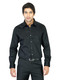
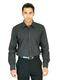
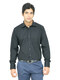
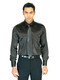
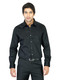
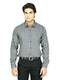
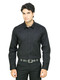
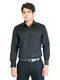
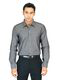

In [ ]:
imgs_fin=[]

for id in ids_new:
  imgs_fin.append(images[id])
display_result_in_loop(imgs_fin)

In [ ]:
filtered_df['weighted_sum'] = 0.1 * filtered_df['Epoch10']+0.2 * filtered_df['Epoch30']+0.4 * filtered_df['Epoch50']+0.8 * filtered_df['Epoch80']+1.6 * filtered_df['Epoch100']

<ipython-input-520-41baa08bf9b5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['weighted_sum'] = 0.1 * filtered_df['Epoch10']+0.2 * filtered_df['Epoch30']+0.4 * filtered_df['Epoch50']+0.8 * filtered_df['Epoch80']+1.6 * filtered_df['Epoch100']


In [ ]:
filtered_df

,Image_ids,Epoch10,Epoch30,Epoch50,Epoch80,Epoch100,frequency,in_cluster,weighted_sum
9,3519,0,0,1,0,0,1,1,0.4
14,4187,1,1,1,1,1,5,1,3.1
11,5202,0,1,0,0,0,1,1,0.2
0,12417,1,0,0,1,1,3,1,2.5
20,27245,0,1,0,0,1,2,1,1.8
6,29863,0,0,1,1,1,3,1,2.8
3,34322,1,0,0,1,1,3,1,2.5
7,34616,0,0,0,1,0,1,1,0.8
5,42532,0,0,1,1,1,3,1,2.8


In [ ]:
filtered_df['ranking_score'] =filtered_df['frequency']*filtered_df['weighted_sum']

<ipython-input-522-aa3ab1d63061>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['ranking_score'] =filtered_df['frequency']*filtered_df['weighted_sum']


In [ ]:
filtered_df

,Image_ids,Epoch10,Epoch30,Epoch50,Epoch80,Epoch100,frequency,in_cluster,weighted_sum,ranking_score
9,3519,0,0,1,0,0,1,1,0.4,0.4
14,4187,1,1,1,1,1,5,1,3.1,15.5
11,5202,0,1,0,0,0,1,1,0.2,0.2
0,12417,1,0,0,1,1,3,1,2.5,7.5
20,27245,0,1,0,0,1,2,1,1.8,3.6
6,29863,0,0,1,1,1,3,1,2.8,8.4
3,34322,1,0,0,1,1,3,1,2.5,7.5
7,34616,0,0,0,1,0,1,1,0.8,0.8
5,42532,0,0,1,1,1,3,1,2.8,8.4


#Based on Rank

In [ ]:
filtered_df_rank = filtered_df.sort_values(by = ['ranking_score'],ascending=False)

In [ ]:
filtered_df_ids_list=filtered_df_rank['Image_ids'].to_list()
flitered_df_ids_list_top_10=filtered_df_ids_list


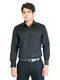
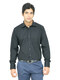
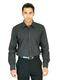
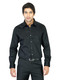
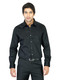
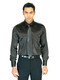
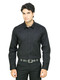
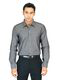
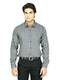

[4187, 29863, 42532, 12417, 34322, 27245, 34616, 3519, 5202]


In [ ]:
imgs_fin=[]

for id in flitered_df_ids_list_top_10:
  imgs_fin.append(images[id])
display_result_in_loop(imgs_fin)
print(flitered_df_ids_list_top_10)

#Based on Weight

In [ ]:
filtered_df_weight = filtered_df.sort_values(by = ['weighted_sum'],ascending=False)

In [ ]:
filtered_df_weight

,Image_ids,Epoch10,Epoch30,Epoch50,Epoch80,Epoch100,frequency,in_cluster,weighted_sum,ranking_score
14,4187,1,1,1,1,1,5,1,3.1,15.5
6,29863,0,0,1,1,1,3,1,2.8,8.4
5,42532,0,0,1,1,1,3,1,2.8,8.4
0,12417,1,0,0,1,1,3,1,2.5,7.5
3,34322,1,0,0,1,1,3,1,2.5,7.5
20,27245,0,1,0,0,1,2,1,1.8,3.6
7,34616,0,0,0,1,0,1,1,0.8,0.8
9,3519,0,0,1,0,0,1,1,0.4,0.4
11,5202,0,1,0,0,0,1,1,0.2,0.2


In [ ]:
filtered_df_ids_list=filtered_df_weight['Image_ids'].to_list()
flitered_df_ids_list_top_10=filtered_df_ids_list


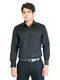
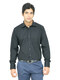
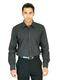
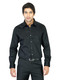
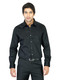
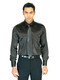
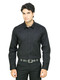
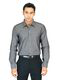
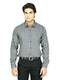

[4187, 29863, 42532, 12417, 34322, 27245, 34616, 3519, 5202]


In [ ]:
imgs_fin=[]

for id in flitered_df_ids_list_top_10:
  imgs_fin.append(images[id])
display_result_in_loop(imgs_fin)
print(flitered_df_ids_list_top_10)

#Based on Frequency and weight

In [ ]:
filtered_df_frequency_weight = filtered_df.sort_values(by = ['frequency','weighted_sum'],ascending=False)

In [ ]:
filtered_df_frequency_weight

,Image_ids,Epoch10,Epoch30,Epoch50,Epoch80,Epoch100,frequency,in_cluster,weighted_sum,ranking_score
14,4187,1,1,1,1,1,5,1,3.1,15.5
6,29863,0,0,1,1,1,3,1,2.8,8.4
5,42532,0,0,1,1,1,3,1,2.8,8.4
0,12417,1,0,0,1,1,3,1,2.5,7.5
3,34322,1,0,0,1,1,3,1,2.5,7.5
20,27245,0,1,0,0,1,2,1,1.8,3.6
7,34616,0,0,0,1,0,1,1,0.8,0.8
9,3519,0,0,1,0,0,1,1,0.4,0.4
11,5202,0,1,0,0,0,1,1,0.2,0.2


In [ ]:
filtered_df_ids_list=filtered_df_frequency_weight['Image_ids'].to_list()
flitered_df_ids_list_top_10=filtered_df_ids_list


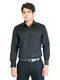
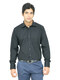
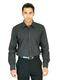
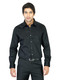
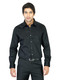
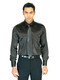
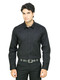
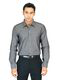
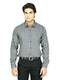

[4187, 29863, 42532, 12417, 34322, 27245, 34616, 3519, 5202]


In [ ]:
imgs_fin=[]

for id in flitered_df_ids_list_top_10:
  imgs_fin.append(images[id])
display_result_in_loop(imgs_fin)
print(flitered_df_ids_list_top_10)